In [ ]:
import pandas as pd
import numpy as np
import re
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, AdditiveAttention, Concatenate, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive

In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('medquad.csv')

Saving medquad.csv to medquad.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('medquad.csv')

In [ ]:
print("Dataset shape:", df.shape)
print("First few rows of the dataset:")
print(df.head())

Dataset shape: (16406, 4)
First few rows of the dataset:
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  


In [ ]:
df = df.drop(columns=['source', 'focus_area'])
print("Dataset after dropping 'source' and 'focus_area':")
print(df.head())

Dataset after dropping 'source' and 'focus_area':
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer  
0  Glaucoma is a group of diseases that can damag...  
1  Nearly 2.7 million people have glaucoma, a lea...  
2  Symptoms of Glaucoma  Glaucoma can develop in ...  
3  Although open-angle glaucoma cannot be cured, ...  
4  Glaucoma is a group of diseases that can damag...  


In [ ]:
def clean_text(text):
    text = text.replace('\n', ' ')  # Remove line breaks
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.strip()

In [ ]:
df['question'] = df['question'].fillna("")
df['answer'] = df['answer'].fillna("")
df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

In [ ]:
df = df.drop_duplicates(subset=['question', 'answer'])

In [ ]:
question_tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
question_tokenizer.fit_on_texts(df['question'])
question_sequences = question_tokenizer.texts_to_sequences(df['question'])

In [ ]:
answer_tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
answer_tokenizer.fit_on_texts(df['answer'])
answer_sequences = answer_tokenizer.texts_to_sequences(df['answer'])

In [ ]:
max_question_length = 26
max_answer_length = 150

In [ ]:
padded_questions = pad_sequences(question_sequences, maxlen=max_question_length, padding='post')
padded_answers = pad_sequences(answer_sequences, maxlen=max_answer_length, padding='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_questions, padded_answers, test_size=0.2, random_state=42
)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (13086, 26) (13086, 150)
Test set shape: (3272, 26) (3272, 150)


In [ ]:
decoder_inputs_train = y_train[:, :-1]
decoder_targets_train = y_train[:, 1:]
decoder_inputs_test = y_test[:, :-1]
decoder_targets_test = y_test[:, 1:]

In [ ]:
question_vocab_size = len(question_tokenizer.word_index) + 1
answer_vocab_size = len(answer_tokenizer.word_index) + 1

In [ ]:
encoder_inputs = Input(shape=(max_question_length,))
encoder_embedding = Embedding(input_dim=question_vocab_size, output_dim=256)(encoder_inputs)
encoder_lstm = LSTM(512, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

In [ ]:
decoder_inputs = Input(shape=(max_answer_length - 1,))
decoder_embedding = Embedding(input_dim=answer_vocab_size, output_dim=256)(decoder_inputs)
decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

In [ ]:
attention = AdditiveAttention()
attention_output = attention([decoder_outputs, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_output])

In [ ]:
decoder_dense = TimeDistributed(Dense(answer_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_combined_context)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 26)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 149)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 26, 256)        │      1,208,832 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 149, 256)       │      8,414,464 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 26, 512),      │      1,574,912 │ embedding[0][0]        │
│                           │ (None, 512), (None,    │                │                        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 149, 512),     │      1,574,912 │ embedding_1[0][0],     │
│                           │ (None, 512), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 149, 512)       │              0 │ lstm_1[0][0],          │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 149, 1024)      │              0 │ lstm_1[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 149, 32869)     │     33,690,725 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 46,463,845 (177.25 MB)

 Trainable params: 46,463,845 (177.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_callback = ModelCheckpoint("/content/drive/MyDrive/lstm_attention_model.keras", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(
    [X_train, decoder_inputs_train],
    decoder_targets_train[:, :, np.newaxis],
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_callback]
)

Epoch 1/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 73s 184ms/step - accuracy: 0.3045 - loss: 5.3466 - val_accuracy: 0.4872 - val_loss: 3.6500
Epoch 2/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 58s 178ms/step - accuracy: 0.5094 - loss: 3.4363 - val_accuracy: 0.5505 - val_loss: 2.9922
Epoch 3/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - accuracy: 0.5602 - loss: 2.8458 - val_accuracy: 0.5761 - val_loss: 2.7155
Epoch 4/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - accuracy: 0.5850 - loss: 2.5445 - val_accuracy: 0.5926 - val_loss: 2.5468
Epoch 5/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - accuracy: 0.6046 - loss: 2.3184 - val_accuracy: 0.6044 - val_loss: 2.4372
Epoch 6/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - accuracy: 0.6176 - loss: 2.1616 - val_accuracy: 0.6125 - val_loss: 2.3624
Epoch 7/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - accuracy: 0.6294 - loss: 2.0211 - val_accuracy: 0.6186 - val_loss: 2.3079
Epoch 8/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - accuracy: 0.6495 - loss: 1

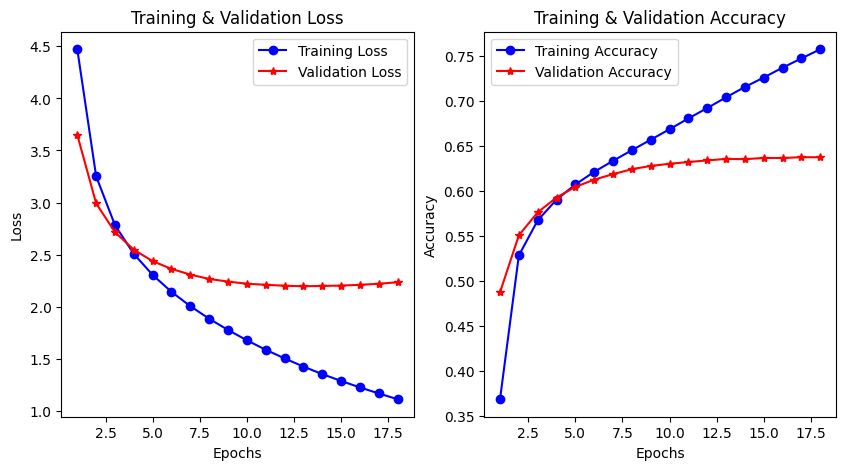

✅ Training graph saved as /content/drive/MyDrive/training_plot.png


In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(10, 5))

# ✅ Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# ✅ Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# ✅ Save Image to Google Drive
plot_path = "/content/drive/MyDrive/training_plot.png"
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"✅ Training graph saved as {plot_path}")

In [ ]:
import tensorflow as tf

# ✅ Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # ✅ Enable memory growth (prevents crashes)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled!")
    except RuntimeError as e:
        print(f"⚠️ Error setting GPU memory growth: {e}")
else:
    print("❌ No GPU detected! Check runtime settings.")


✅ GPU memory growth enabled!


In [ ]:
import numpy as np
import pickle
import tensorflow as tf
import gc
import os

# ✅ Load Model
model = tf.keras.models.load_model("/content/drive/MyDrive/lstm_attention_model.keras")
print("✅ Model loaded successfully!")

# ✅ Load Test Data & Tokenizer
with open("/content/drive/MyDrive/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("/content/drive/MyDrive/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

with open("/content/drive/MyDrive/answer_tokenizer.pkl", "rb") as f:
    answer_tokenizer = pickle.load(f)

# ✅ Set batch size (Reduce if OOM occurs)
batch_size = 16
predictions_path = "/content/drive/MyDrive/predictions_batches"

# ✅ Create folder for saving batches
if not os.path.exists(predictions_path):
    os.makedirs(predictions_path)

with tf.device('/GPU:0'):
    for i in range(0, len(X_test), batch_size):
        batch_X = X_test[i:i + batch_size]
        batch_decoder_inputs = y_test[i:i + batch_size, :-1]

        try:
            # ✅ Predict batch-wise
            batch_predictions = model.predict_on_batch([batch_X, batch_decoder_inputs])

            # ✅ Save each batch separately (Avoids huge memory use)
            np.savez_compressed(f"{predictions_path}/batch_{i}.npz", predictions=batch_predictions)

            print(f"✅ Saved batch {i}/{len(X_test)} to Drive")

            # ✅ Free memory
            del batch_predictions, batch_X, batch_decoder_inputs
            gc.collect()
            tf.keras.backend.clear_session()

        except tf.errors.ResourceExhaustedError:
            print(f"❌ GPU OOM error! Reduce batch size.")
            break  # Stop execution if GPU crashes


✅ Model loaded successfully!
✅ Saved batch 0/3272 to Drive
✅ Saved batch 16/3272 to Drive
✅ Saved batch 32/3272 to Drive
✅ Saved batch 48/3272 to Drive
✅ Saved batch 64/3272 to Drive
✅ Saved batch 80/3272 to Drive
✅ Saved batch 96/3272 to Drive
✅ Saved batch 112/3272 to Drive
✅ Saved batch 128/3272 to Drive
✅ Saved batch 144/3272 to Drive
✅ Saved batch 160/3272 to Drive
✅ Saved batch 176/3272 to Drive
✅ Saved batch 192/3272 to Drive
✅ Saved batch 208/3272 to Drive
✅ Saved batch 224/3272 to Drive
✅ Saved batch 240/3272 to Drive
✅ Saved batch 256/3272 to Drive
✅ Saved batch 272/3272 to Drive
✅ Saved batch 288/3272 to Drive
✅ Saved batch 304/3272 to Drive
✅ Saved batch 320/3272 to Drive
✅ Saved batch 336/3272 to Drive
✅ Saved batch 352/3272 to Drive
✅ Saved batch 368/3272 to Drive
✅ Saved batch 384/3272 to Drive
✅ Saved batch 400/3272 to Drive
✅ Saved batch 416/3272 to Drive
✅ Saved batch 432/3272 to Drive
✅ Saved batch 448/3272 to Drive
✅ Saved batch 464/3272 to Drive
✅ Saved batch 480/3

In [ ]:
import os
import numpy as np
import pickle
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

# ✅ Load y_test & Tokenizer
with open("/content/drive/MyDrive/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)
with open("/content/drive/MyDrive/answer_tokenizer.pkl", "rb") as f:
    answer_tokenizer = pickle.load(f)

# ✅ Initialize Score Lists
bleu_scores, f1_scores, map_scores, mrr_scores = [], [], [], []
rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# ✅ Load each batch, compute scores, and delete after processing
predictions_path = "/content/drive/MyDrive/predictions_batches"
batches = sorted(os.listdir(predictions_path))

for batch_file in batches:
    batch_index = int(batch_file.split("_")[-1].split(".")[0])  # Extract batch index
    batch_data = np.load(os.path.join(predictions_path, batch_file))["predictions"]

    # ✅ Handle last batch properly (it might have fewer samples)
    batch_y_true = y_test[batch_index:batch_index + len(batch_data)]

    if len(batch_y_true) != len(batch_data):
        print(f"⚠️ Mismatch in batch {batch_file}: {len(batch_y_true)} vs {len(batch_data)}")
        continue  # Skip this batch if misaligned

    for true_seq, pred_seq in zip(batch_y_true, batch_data):
        true_tokens = list(set(true_seq[:150]) - {0})  # Convert to list
        pred_tokens = list(set(np.argmax(pred_seq, axis=-1)) - {0})

        # ✅ Ensure same length for true & predicted tokens
        max_len = min(len(true_tokens), len(pred_tokens))
        true_tokens = true_tokens[:max_len]
        pred_tokens = pred_tokens[:max_len]

        # ✅ Compute Scores
        bleu = sentence_bleu([true_tokens], pred_tokens, smoothing_function=SmoothingFunction().method1)
        rouge_results = rouge.score(' '.join(map(str, true_tokens)), ' '.join(map(str, pred_tokens)))

        # ✅ Fix f1_score error
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_tokens, pred_tokens, average='macro', zero_division=0
        )

        map_score = average_precision_score(
            [1 if tok in true_tokens else 0 for tok in pred_tokens],
            [1] * len(pred_tokens)
        )
        mrr = max([1 / (1 + rank) for rank, tok in enumerate(pred_tokens) if tok in true_tokens], default=0)

        # ✅ Store Scores
        bleu_scores.append(bleu)
        for metric in rouge_scores.keys():
            rouge_scores[metric].append(rouge_results[metric].fmeasure)
        f1_scores.append(f1)
        map_scores.append(map_score)
        mrr_scores.append(mrr)

    # ✅ Delete batch file after processing
    os.remove(os.path.join(predictions_path, batch_file))
    print(f"✅ Processed & Deleted {batch_file}")

# ✅ Compute Final Averages
final_bleu = np.mean(bleu_scores)
final_rouge = {k: np.mean(v) for k, v in rouge_scores.items()}
final_f1 = np.mean(f1_scores)
final_map = np.mean(map_scores)
final_mrr = np.mean(mrr_scores)

# ✅ Save Results to Google Drive
results_path = "/content/drive/MyDrive/evaluation_results.txt"
with open(results_path, "w") as f:
    f.write(f"BLEU Score: {final_bleu:.4f}\n")
    f.write(f"ROUGE Scores: {final_rouge}\n")
    f.write(f"F1-Score: {final_f1:.4f}\n")
    f.write(f"MAP Score: {final_map:.4f}\n")
    f.write(f"MRR Score: {final_mrr:.4f}\n")

print(f"✅ Final performance metrics saved to Google Drive: {results_path}")


✅ Processed & Deleted batch_0.npz
✅ Processed & Deleted batch_1008.npz
✅ Processed & Deleted batch_1024.npz
✅ Processed & Deleted batch_1040.npz
✅ Processed & Deleted batch_1056.npz
✅ Processed & Deleted batch_1072.npz
✅ Processed & Deleted batch_1088.npz
✅ Processed & Deleted batch_1104.npz
✅ Processed & Deleted batch_112.npz
✅ Processed & Deleted batch_1120.npz
✅ Processed & Deleted batch_1136.npz
✅ Processed & Deleted batch_1152.npz
✅ Processed & Deleted batch_1168.npz
✅ Processed & Deleted batch_1184.npz
✅ Processed & Deleted batch_1200.npz
✅ Processed & Deleted batch_1216.npz
✅ Processed & Deleted batch_1232.npz
✅ Processed & Deleted batch_1248.npz
✅ Processed & Deleted batch_1264.npz
✅ Processed & Deleted batch_128.npz


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


✅ Processed & Deleted batch_1280.npz
✅ Processed & Deleted batch_1296.npz
✅ Processed & Deleted batch_1312.npz
✅ Processed & Deleted batch_1328.npz
✅ Processed & Deleted batch_1344.npz
✅ Processed & Deleted batch_1360.npz
✅ Processed & Deleted batch_1376.npz
✅ Processed & Deleted batch_1392.npz
✅ Processed & Deleted batch_1408.npz
✅ Processed & Deleted batch_1424.npz
✅ Processed & Deleted batch_144.npz
✅ Processed & Deleted batch_1440.npz
✅ Processed & Deleted batch_1456.npz
✅ Processed & Deleted batch_1472.npz
✅ Processed & Deleted batch_1488.npz
✅ Processed & Deleted batch_1504.npz
✅ Processed & Deleted batch_1520.npz
✅ Processed & Deleted batch_1536.npz
✅ Processed & Deleted batch_1552.npz
✅ Processed & Deleted batch_1568.npz
✅ Processed & Deleted batch_1584.npz
✅ Processed & Deleted batch_16.npz
✅ Processed & Deleted batch_160.npz
✅ Processed & Deleted batch_1600.npz
✅ Processed & Deleted batch_1616.npz
✅ Processed & Deleted batch_1632.npz
✅ Processed & Deleted batch_1648.npz
✅ Pro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


✅ Processed & Deleted batch_1824.npz
✅ Processed & Deleted batch_1840.npz
✅ Processed & Deleted batch_1856.npz
✅ Processed & Deleted batch_1872.npz
✅ Processed & Deleted batch_1888.npz
✅ Processed & Deleted batch_1904.npz
✅ Processed & Deleted batch_192.npz
✅ Processed & Deleted batch_1920.npz
✅ Processed & Deleted batch_1936.npz
✅ Processed & Deleted batch_1952.npz
✅ Processed & Deleted batch_1968.npz
✅ Processed & Deleted batch_1984.npz
✅ Processed & Deleted batch_2000.npz
✅ Processed & Deleted batch_2016.npz
✅ Processed & Deleted batch_2032.npz
✅ Processed & Deleted batch_2048.npz


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


✅ Processed & Deleted batch_2064.npz
✅ Processed & Deleted batch_208.npz
✅ Processed & Deleted batch_2080.npz
✅ Processed & Deleted batch_2096.npz
✅ Processed & Deleted batch_2112.npz
✅ Processed & Deleted batch_2128.npz
✅ Processed & Deleted batch_2144.npz
✅ Processed & Deleted batch_2160.npz
✅ Processed & Deleted batch_2176.npz
✅ Processed & Deleted batch_2192.npz
✅ Processed & Deleted batch_2208.npz
✅ Processed & Deleted batch_2224.npz
✅ Processed & Deleted batch_224.npz
✅ Processed & Deleted batch_2240.npz
✅ Processed & Deleted batch_2256.npz
✅ Processed & Deleted batch_2272.npz
✅ Processed & Deleted batch_2288.npz
✅ Processed & Deleted batch_2304.npz
✅ Processed & Deleted batch_2320.npz
✅ Processed & Deleted batch_2336.npz
✅ Processed & Deleted batch_2352.npz
✅ Processed & Deleted batch_2368.npz
✅ Processed & Deleted batch_2384.npz
✅ Processed & Deleted batch_240.npz
✅ Processed & Deleted batch_2400.npz
✅ Processed & Deleted batch_2416.npz
✅ Processed & Deleted batch_2432.npz
✅ Pr

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


✅ Processed & Deleted batch_2880.npz
✅ Processed & Deleted batch_2896.npz
✅ Processed & Deleted batch_2912.npz
✅ Processed & Deleted batch_2928.npz
✅ Processed & Deleted batch_2944.npz
✅ Processed & Deleted batch_2960.npz
✅ Processed & Deleted batch_2976.npz
✅ Processed & Deleted batch_2992.npz


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


✅ Processed & Deleted batch_3008.npz
✅ Processed & Deleted batch_3024.npz
✅ Processed & Deleted batch_304.npz
✅ Processed & Deleted batch_3040.npz
✅ Processed & Deleted batch_3056.npz
✅ Processed & Deleted batch_3072.npz
✅ Processed & Deleted batch_3088.npz
✅ Processed & Deleted batch_3104.npz
✅ Processed & Deleted batch_3120.npz
✅ Processed & Deleted batch_3136.npz
✅ Processed & Deleted batch_3152.npz
✅ Processed & Deleted batch_3168.npz
✅ Processed & Deleted batch_3184.npz


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


✅ Processed & Deleted batch_32.npz
✅ Processed & Deleted batch_320.npz
✅ Processed & Deleted batch_3200.npz
✅ Processed & Deleted batch_3216.npz
✅ Processed & Deleted batch_3232.npz
✅ Processed & Deleted batch_3248.npz
✅ Processed & Deleted batch_3264.npz


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


✅ Processed & Deleted batch_336.npz
✅ Processed & Deleted batch_352.npz
✅ Processed & Deleted batch_368.npz
✅ Processed & Deleted batch_384.npz
✅ Processed & Deleted batch_400.npz
✅ Processed & Deleted batch_416.npz
✅ Processed & Deleted batch_432.npz
✅ Processed & Deleted batch_448.npz
✅ Processed & Deleted batch_464.npz
✅ Processed & Deleted batch_48.npz
✅ Processed & Deleted batch_480.npz
✅ Processed & Deleted batch_496.npz
✅ Processed & Deleted batch_512.npz
✅ Processed & Deleted batch_528.npz
✅ Processed & Deleted batch_544.npz
✅ Processed & Deleted batch_560.npz
✅ Processed & Deleted batch_576.npz
✅ Processed & Deleted batch_592.npz
✅ Processed & Deleted batch_608.npz
✅ Processed & Deleted batch_624.npz
✅ Processed & Deleted batch_64.npz
✅ Processed & Deleted batch_640.npz
✅ Processed & Deleted batch_656.npz
✅ Processed & Deleted batch_672.npz
✅ Processed & Deleted batch_688.npz
✅ Processed & Deleted batch_704.npz
✅ Processed & Deleted batch_720.npz
✅ Processed & Deleted batch_73

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


✅ Processed & Deleted batch_752.npz


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


✅ Processed & Deleted batch_768.npz
✅ Processed & Deleted batch_784.npz
✅ Processed & Deleted batch_80.npz
✅ Processed & Deleted batch_800.npz
✅ Processed & Deleted batch_816.npz
✅ Processed & Deleted batch_832.npz
✅ Processed & Deleted batch_848.npz
✅ Processed & Deleted batch_864.npz
✅ Processed & Deleted batch_880.npz
✅ Processed & Deleted batch_896.npz
✅ Processed & Deleted batch_912.npz
✅ Processed & Deleted batch_928.npz
✅ Processed & Deleted batch_944.npz
✅ Processed & Deleted batch_96.npz
✅ Processed & Deleted batch_960.npz
✅ Processed & Deleted batch_976.npz
✅ Processed & Deleted batch_992.npz
✅ Final performance metrics saved to Google Drive: /content/drive/MyDrive/evaluation_results.txt


In [ ]:
results_path = "/content/drive/MyDrive/evaluation_results.txt"

# ✅ Print the results
with open(results_path, "r") as f:
    results = f.read()
    print("📊 Final Evaluation Results:\n", results)


📊 Final Evaluation Results:
 BLEU Score: 0.3108
ROUGE Scores: {'rouge1': 0.6015205280596936, 'rouge2': 0.35333468654223305, 'rougeL': 0.5644238266352605}
F1-Score: 0.2342
MAP Score: 0.6015
MRR Score: 0.8613



In [ ]:
import numpy as np

def beam_search_decoder(input_seq, beam_width=3):
    # ✅ Tokenize and pad the question
    padded_seq = pad_sequences(question_tokenizer.texts_to_sequences([input_seq]), maxlen=max_question_length, padding='post')

    # ✅ Initialize decoder input with <START> token (Assuming 2 is <START>)
    decoder_input = np.zeros((1, max_answer_length - 1))
    decoder_input[0, 0] = 2  # Start token

    sequences = [[[], 1.0]]  # Start with empty sequence & score of 1.0

    for i in range(min(max_answer_length - 1, len(padded_seq[0]))):
        all_candidates = []
        for seq, score in sequences:
            prediction = model.predict([padded_seq, decoder_input], verbose=0)
            top_candidates = np.argsort(prediction[0, i])[-beam_width:]  # ✅ Select top-k tokens

            for token in top_candidates:
                if token == 3:  # Stop if `<END>` token is generated (Assuming 3 is <END>)
                    continue

                new_seq = seq + [token]
                new_score = score * prediction[0, i, token]  # Multiply probabilities
                all_candidates.append([new_seq, new_score])

        if not all_candidates:  # ✅ If no valid candidates, return <No response>
            return "<No response>"

        # ✅ Keep only top `beam_width` sequences
        sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
        decoder_input[0, len(sequences[0][0])] = sequences[0][0][-1]  # ✅ Update decoder input

    # ✅ Convert token IDs back to words
    predicted_tokens = sequences[0][0]
    predicted_text = ' '.join([answer_tokenizer.index_word.get(token, "<UNK>") for token in predicted_tokens if token > 0])

    return predicted_text if predicted_text else "<No response>"

# ✅ Test Beam Search with the Fix
question = "what is kidney"
answer = beam_search_decoder(question, beam_width=5)
print(f"✅ **Beam Search Answer:** {answer}")


✅ **Beam Search Answer:** kidneys are two beanshaped organs each about the size and shape for a fist they are located just just below the rib cage one on each
